In [1]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 646 kB 9.6 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 


In [17]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
import graphlearning as gl
from scipy import sparse, linalg
from sklearn.cluster import KMeans
from scipy.special import softmax
from sklearn.decomposition import PCA as sklearn_pca
import urllib.request
import scipy.io

In [3]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [4]:
#Function to plot segmentation by laplace and poisson learning
def plot_image_segmentation(train_ind, labels, laplace_labels, poisson_labels, image_shape):
    laplace_seg = np.reshape(laplace_labels,image_shape[:2])
    poisson_seg = np.reshape(poisson_labels,image_shape[:2])
    gt = np.reshape(labels,image_shape[:2])

    # Create blank array of zeros same size as original image
    overlay_array = np.zeros((image_shape[0], image_shape[1]), dtype = int)

    # For loop that makes overlay array entries 1 where a label is taken from
    for i in range(len(train_ind)):
        y_loc = train_ind[i] // image_shape[1]
        x_loc = train_ind[i] % image_shape[0]

        overlay_array[y_loc, x_loc] = 1

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    ax1.set_title('Laplace Segmentation')
    ax1.imshow(laplace_seg)
    ax2.set_title('Poisson Segmentation')
    ax2.imshow(poisson_seg)
    ax3.set_title('Labeled Points')
    ax3.imshow(gt)
    ax3.imshow(overlay_array, alpha=0.7, cmap='gray')
    plt.show()

#Image preprocessing methods

In [5]:
## Function for Non-Local Means Method
def non_local_means(image, d):
  
  ## Pad the image with mirror reflections of itself with a width d
  pad = (d,d)
  padimage = np.pad(image,(pad,pad,(0,0)),mode='reflect') #(top,bottom),(left,right),(0,0)

  ## For the ith pixel, make a (2d + 1) by (2d + 1) patch centered at pixel i
  patches = extract_patches_2d(padimage, (2*d+1,2*d+1))

  ## For the jth, (j = 1; 2; 3) band, apply a Gaussian kernel on this patch
  u = np.zeros((2*d+1,2*d+1))
  u[d,d] = 1
  G = gaussian_filter(u,d/2,mode='constant',cval=0)
  patches = patches * G[np.newaxis,:,:,np.newaxis]

  ## Form the feature matrix F by letting each row of F be a feature vector of a pixel
  F = patches.reshape((patches.shape[0],patches.shape[1]*patches.shape[2]*patches.shape[3]))
  print("feature vector shape: ", F.shape)

  return F

In [6]:
#Function to perform PCA on image
def PCA(image, component=False):

  #Perform PCA with 60 components
  pca = sklearn_pca(n_components=60)
  X = image.reshape(image.shape[0]*image.shape[1],image.shape[2])
  pca.fit(X)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_image = pca.fit_transform(X)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  pca_image = pca_image.reshape(image.shape[0], image.shape[1], num_components)
  print("pca image shape: ", pca_image.shape)
  
  if component==True:
    return pca_image, num_components
  return pca_image

#Active learning methods

In [28]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #Laplace Learning
  u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
  labels_laplace = np.argmax(u_laplace, axis=1)
  laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

  #Poisson Learning
  u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
  labels_poisson = np.argmax(u_poisson, axis=1)
  poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

  #Output results
  # if plot is True: 
  #   scatterplot(data, labels, train_ind, []) 
  #   laplace_poisson(data, labels_laplace, labels_poisson)
  print('Number of Labels,Accuracy')
  print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
  print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

  return train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson

In [29]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [30]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = uncertainty(u_laplace, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    new_train_ind = np.argmax(obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [31]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      return K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
  
#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)

    return C[np.ix_(not_k, not_k)]

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=100 #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = v_opt(C, train_ind)
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [32]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=100 #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = sigma_opt(C, train_ind) 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [33]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=100 #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = mc_vopt(C, u_laplace, train_ind)
    stats(unc_values, 'mc_vopt') 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [34]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-Laplace")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=100 #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = model_change(C, u_laplace, train_ind) 
    stats(unc_values, 'mc_laplace')
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [35]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sigmaopt_acc, mcvopt_acc, method, filename=None):
  plt.figure(figsize=(10,5))
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sigmaopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%method)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sigmaopt_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

#Active learning on SalinasA image dataset

image shape: (83, 86, 224)


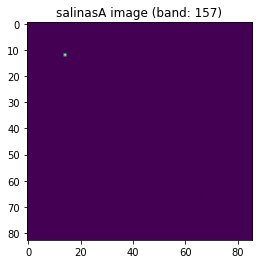

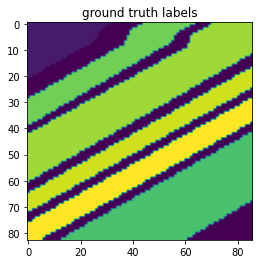

In [15]:
## Import the hyperspectral dataset
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/d/df/SalinasA.mat', 'salinasA.mat')
data = scipy.io.loadmat('salinasA.mat')
image = data['salinasA']
print("image shape:",image.shape)

## Display a random sample band of the image
rand_slice = np.random.randint(image.shape[2])
plt.title('salinasA image (band: %d)'%rand_slice)
plt.imshow(image[:,:,rand_slice])
plt.show()

## Import the ground truth labels
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/a/aa/SalinasA_gt.mat', 'salinasA_gt.mat')
data = scipy.io.loadmat('salinasA_gt.mat')
gt = data['salinasA_gt']
labels = gt.flatten().astype(int)
map = np.arange(15)
map[10:15] = np.arange(2,7)
labels = map[labels]
plt.title('ground truth labels')
plt.imshow(gt)
plt.show()

feature vector shape:  (7138, 5600)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.098067% training data
Number of Labels,Accuracy
Laplace: 7,58.589
Poisson: 7,61.773
0.0 0.00014023278642546626
Number of Labels,Accuracy
Laplace: 8,67.125
Poisson: 8,62.889
0.0 0.00014025245441795232
Number of Labels,Accuracy
Laplace: 9,68.930
Poisson: 9,67.653
0.0 0.00014027212792818068
Number of Labels,Accuracy
Laplace: 10,68.939
Poisson: 10,67.551
0.0 0.00014029180695847364
Number of Labels,Accuracy
Laplace: 11,68.935
Poisson: 11,69.903
0.0 0.00014031149151115475
Number of Labels,Accuracy
Laplace: 12,69.534
Poisson: 12,68.327
0.0 0.000140331181588549
Number of Labels,Accuracy
Laplace: 13,73.796
Poisson: 13,68.295
0.0 0.00014035087719298245
Number of Labels,Acc

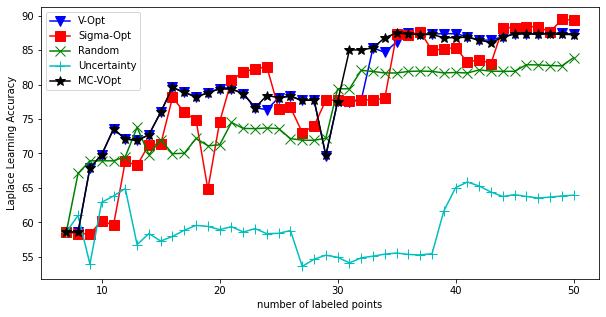

rand: 83.902 unc: 65.859 vopt: 87.447 sopt: 89.463 mc-vopt: 87.484


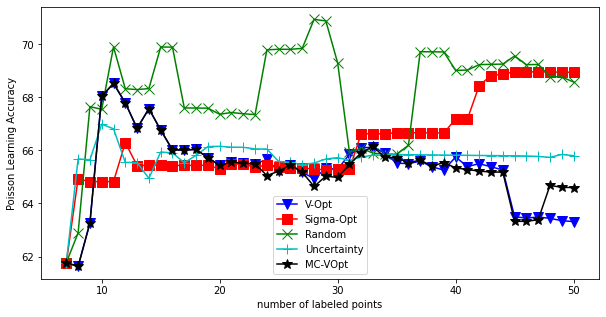

rand: 70.942 unc: 66.989 vopt: 68.528 sopt: 68.969 mc-vopt: 68.528


In [38]:
#1. Non-local means
F = non_local_means(image, 2)
W = weight_matrix(F)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 50)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 50)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 50)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 50)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 50)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='NLM_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='NLM_Poisson')

feature vector shape:  (7138, 5600)
Total Variation (41 components):  0.9988904418590825
pca image shape:  (83, 86, 41)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.098067% training data
Number of Labels,Accuracy
Laplace: 7,56.864
Poisson: 7,65.923
0.0 0.00014023278642546626
Number of Labels,Accuracy
Laplace: 8,59.088
Poisson: 8,64.783
0.0 0.00014025245441795232
Number of Labels,Accuracy
Laplace: 9,67.611
Poisson: 9,68.130
0.0 0.00014027212792818068
Number of Labels,Accuracy
Laplace: 10,73.808
Poisson: 10,68.112
0.0 0.00014029180695847364
Number of Labels,Accuracy
Laplace: 11,73.986
Poisson: 11,68.107
0.0 0.00014031149151115475
Number of Labels,Accuracy
Laplace: 12,74.109
Poisson: 12,68.103
0.0 0.000140331181588549
Number of Labels,Accuracy
Laplace: 13,75.396
Poi

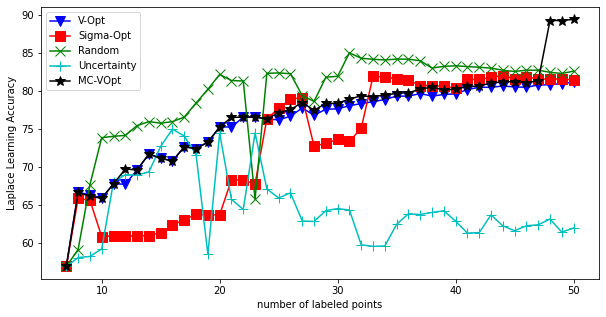

rand: 84.973 unc: 74.937 vopt: 81.123 sopt: 81.971 mc-vopt: 89.376


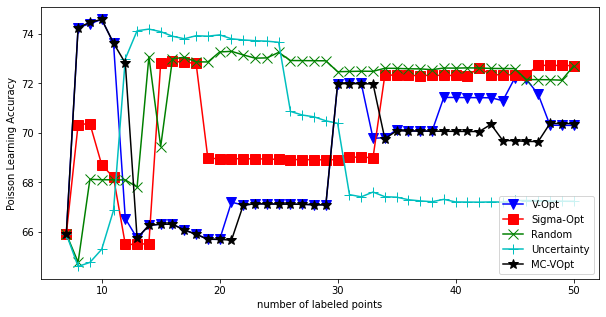

rand: 73.289 unc: 74.186 vopt: 74.579 sopt: 72.901 mc-vopt: 74.579


In [39]:
#2. Nonlocalmeans-PCA
feat_vec = non_local_means(image, 2)
feat_vec = feat_vec.reshape(image.shape[0], image.shape[1], feat_vec.shape[1])
pca_image = PCA(feat_vec)
W = weight_matrix(pca_image.reshape(image.shape[0]*image.shape[1], pca_image.shape[2]))
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 50)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 50)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 50)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 50)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 50)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='NLM-PCA_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='NLM-PCA_Poisson')

Total Variation (9 components):  0.999600050322022
pca image shape:  (83, 86, 9)
feature vector shape:  (7138, 225)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.098067% training data
Number of Labels,Accuracy
Laplace: 7,56.626
Poisson: 7,65.292
0.0 0.00014023278642546626
Number of Labels,Accuracy
Laplace: 8,64.180
Poisson: 8,57.714
0.0 0.00014025245441795232
Number of Labels,Accuracy
Laplace: 9,63.613
Poisson: 9,57.722
0.0 0.00014027212792818068
Number of Labels,Accuracy
Laplace: 10,66.681
Poisson: 10,64.534
0.0 0.00014029180695847364
Number of Labels,Accuracy
Laplace: 11,66.367
Poisson: 11,64.529
0.0 0.00014031149151115475
Number of Labels,Accuracy
Laplace: 12,66.124
Poisson: 12,64.398
0.0 0.000140331181588549
Number of Labels,Accuracy
Lapla

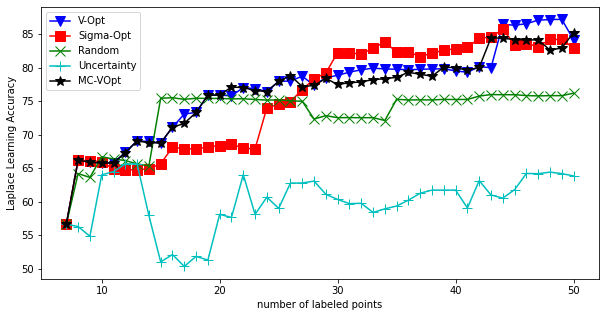

rand: 76.185 unc: 65.642 vopt: 87.191 sopt: 85.734 mc-vopt: 85.229


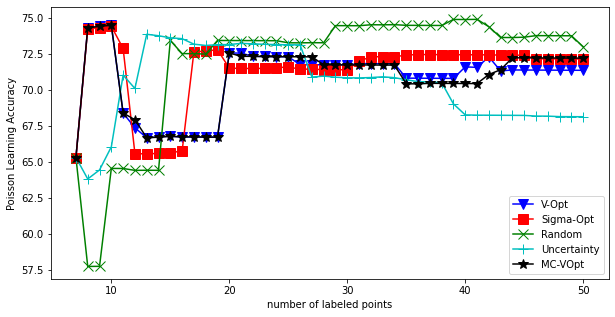

rand: 74.905 unc: 73.867 vopt: 74.495 sopt: 74.425 mc-vopt: 74.495


In [36]:
#3. PCA-Nonlocalmeans
pca_image = PCA(image)
F = non_local_means(pca_image, 2)
W = weight_matrix(F)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 50)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 50)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 50)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 50)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 50)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='PCA-NLM_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='PCA-NLM_Poisson')

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=True
k=12 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.098067% training data
Number of Labels,Accuracy
Laplace: 7,42.266
Poisson: 7,46.768
0.0 0.00014023278642546626
Number of Labels,Accuracy
Laplace: 8,47.055
Poisson: 8,43.717
0.0 0.00014025245441795232
Number of Labels,Accuracy
Laplace: 9,47.342
Poisson: 9,44.859
0.0 0.00014027212792818068
Number of Labels,Accuracy
Laplace: 10,46.605
Poisson: 10,44.992
0.0 0.00014029180695847364
Number of Labels,Accuracy
Laplace: 11,46.948
Poisson: 11,45.321
0.0 0.00014031149151115475
Number of Labels,Accuracy
Laplace: 12,46.955
Poisson: 12,45.313
0.0 0.000140331181588549
Number of Labels,Accuracy
Laplace: 13,48.168
Poisson: 13,49.446
0.0 0.00014035087719298245
Number of Labels,Accuracy
Laplace: 1

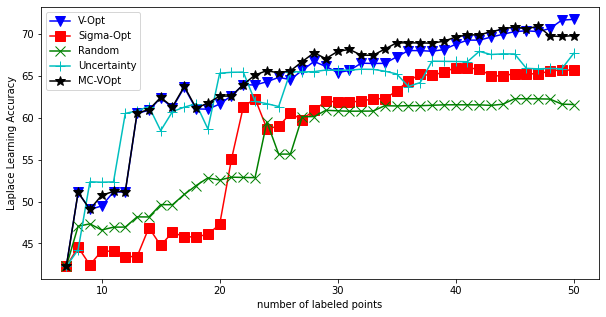

rand: 62.244 unc: 67.883 vopt: 71.699 sopt: 65.934 mc-vopt: 70.893


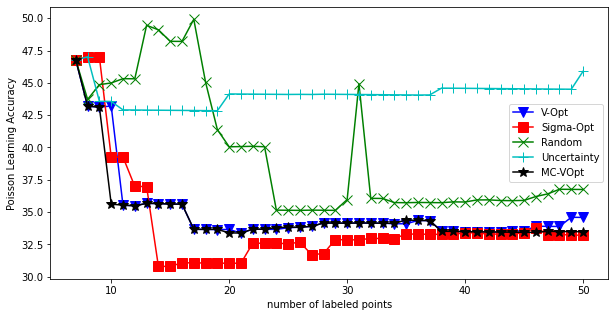

rand: 49.909 unc: 47.013 vopt: 46.768 sopt: 47.013 mc-vopt: 46.768


In [40]:
#4. Nonlocalmeans-VAE
M = np.load('SalinasA_nlm_vae.npz')
data = M['data']
W = weight_matrix(data)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 50)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 50)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 50)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 50)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 50)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='NLM-VAE_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='NLM-VAE_Poisson')

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.098067% training data
Number of Labels,Accuracy
Laplace: 7,54.831
Poisson: 7,59.767
0.0 0.00014023278642546626
Number of Labels,Accuracy
Laplace: 8,54.979
Poisson: 8,61.837
0.0 0.00014025245441795232
Number of Labels,Accuracy
Laplace: 9,53.303
Poisson: 9,61.734
0.0 0.00014027212792818068
Number of Labels,Accuracy
Laplace: 10,59.371
Poisson: 10,61.728
0.0 0.00014029180695847364
Number of Labels,Accuracy
Laplace: 11,59.352
Poisson: 11,61.723
0.0 0.00014031149151115475
Number of Labels,Accuracy
Laplace: 12,59.248
Poisson: 12,61.339
0.0 0.000140331181588549
Number of Labels,Accuracy
Laplace: 13,59.340
Poisson: 13,61.530
0.0 0.00014035087719298245
Number of Labels,Accuracy
Laplace: 14,60.809
Poisson: 14

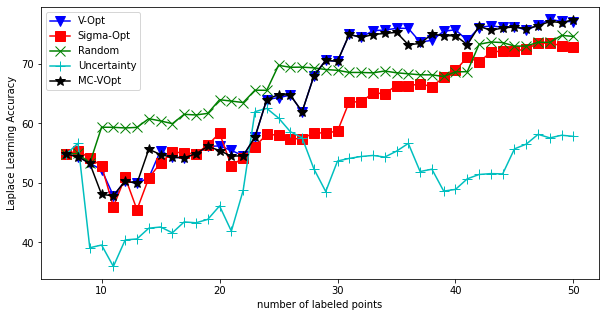

rand: 74.806 unc: 62.539 vopt: 77.504 sopt: 73.516 mc-vopt: 77.441


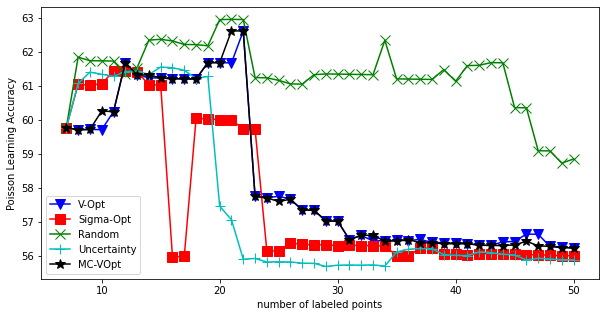

rand: 62.948 unc: 61.547 vopt: 62.605 sopt: 61.428 mc-vopt: 62.611


In [41]:
#5. PCA-NLM-VAE
M = np.load('SalinasA_pca_nlm_vae.npz')
data = M['data']
W = weight_matrix(data)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 50)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 50)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 50)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 50)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 50)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='PCA-NLM-VAE_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='PCA-NLM-VAE_Poisson')